In [1]:
from Bio import Phylo
from io import StringIO
import networkx as nx
import pandas as pd
from utilities import *
import matplotlib.pyplot as plt

problin_file = "/n/fs/ragr-research/projects/problin_experiments/Real_biodata/run_kptracer/result_trees/pruned_1461/problin_1461.nwk"
startle_file = "/n/fs/ragr-research/projects/problin_experiments/Real_biodata/run_kptracer/result_trees/pruned_1461/startle_1461.nwk"
casshybrid_file = "/n/fs/ragr-research/projects/problin_experiments/Real_biodata/run_kptracer/result_trees/pruned_1461/casshybrid_1461.nwk"
df_kp_meta = pd.read_csv(f'/n/fs/ragr-data/users/palash/multi-linTracer/kp_data/KPTracer-Data/KPTracer_meta.csv', index_col = 0)
df_character_matrix_Fam_1 = pd.read_csv('/n/fs/ragr-data/users/palash/multi-linTracer/kp_data/KPTracer-Data/trees/3724_NT_All_character_matrix.txt',
                                        index_col = 0, sep='\t', dtype=str)
df_character_matrix_Fam_1 = df_character_matrix_Fam_1.replace('-', '-1')

In [2]:
cell_site_info_1 = df_kp_meta.loc[df_character_matrix_Fam_1.index]['SubTumor']
for cell, site in cell_site_info_1.items():
    if len(site.split('_')) > 3:
        cell_site_info_1[cell] = '_'.join(site.split('_')[:-1])
        
cell_site_info_2 = df_kp_meta.loc[df_character_matrix_Fam_1.index]['SubTumor']
for cell, site in cell_site_info_2.items():
    if len(site.split('_')) > 3: 
        cell_site_info_2[cell] = '_'.join(site.split('_')[-2:])

In [3]:
def get_brlen(u, v, edge_attr):
    return edge_attr['weight']
    
def computeG(T, cell_site_info, state_list, cost_labeling, presence_labeling, node):
    min_cost = min(cost_labeling[node])
    if node == 'root':
         for state_idx in range(len(state_list)):
                if cost_labeling[node][state_idx] == min_cost:
                    presence_labeling[node][state_idx] = 1
                else:
                    presence_labeling[node][state_idx] = 0
    else:
        
        parent_node = list(T.pred[node])[0]
        
        for state_idx in range(len(state_list)):
            presence_labeling[node][state_idx] = 0
        
        for parent_state_idx in range(len(state_list)):
            if presence_labeling[parent_node][parent_state_idx] == 1:

                min_cost = np.inf
                for child_state_idx, child_state in enumerate(state_list):
                    if child_state_idx == parent_state_idx:
                        curr_cost = cost_labeling[node][child_state_idx]
                    else:
                        curr_cost = cost_labeling[node][child_state_idx] + 1

                    if curr_cost < min_cost:
                        min_cost = curr_cost
        
                for child_state_idx in range(len(state_list)):
                    if child_state_idx == parent_state_idx:
                        curr_cost = cost_labeling[node][child_state_idx]
                    else:
                        curr_cost = cost_labeling[node][child_state_idx] + 1
                        
                    if curr_cost == min_cost:
                        presence_labeling[node][child_state_idx] = 1
                

    for child in T[node]:
        computeG(T, cell_site_info, state_list, cost_labeling, presence_labeling, child)
        
def update_parsimonious_labeling_counts(T, cell_site_info, state_list, cost_labeling, count_labeling, node):
    if is_leaf(T, node):
        for state_idx, state in enumerate(state_list):
            if state == cell_site_info[node]:
                cost_labeling[node][state_idx] = 0
                count_labeling[node][state_idx] = 1
            else:
                cost_labeling[node][state_idx] = np.inf
                count_labeling[node][state_idx] = 0
    else:
        for child in T[node]:
            update_parsimonious_labeling_counts(T, cell_site_info, state_list, cost_labeling, count_labeling, child)
        
        for parent_state_idx, state in enumerate(state_list):
            cost_labeling[node][parent_state_idx] = 0
            count_labeling[node][parent_state_idx] = 1
            for child in T[node]:
                min_cost = np.inf
                for child_state_idx, child_state in enumerate(state_list):
                    if child_state_idx == parent_state_idx:
                        curr_cost = cost_labeling[child][child_state_idx]
                    else:
                        curr_cost = cost_labeling[child][child_state_idx] + 1

                    if curr_cost < min_cost:
                        min_cost = curr_cost
                        min_child_state_idx = child_state_idx

                cost_labeling[node][parent_state_idx] += min_cost

                curr_child_total_count = 0
                for child_state_idx, child_state in enumerate(state_list):
                    if child_state_idx == parent_state_idx:
                        curr_cost = cost_labeling[child][child_state_idx]
                    else:
                        curr_cost = cost_labeling[child][child_state_idx] + 1

                    if curr_cost == min_cost:
                        curr_child_total_count += count_labeling[child][child_state_idx]

                count_labeling[node][parent_state_idx] *= curr_child_total_count

def count_parsimonious_labelings(T, cell_site_info):
    state_list = list(cell_site_info.unique())
    nstates = len(state_list)
    # state_transition_counter = Counter()
    node_cost_labeling = {node:[None]*nstates for node in T.nodes}
    # print(T.nodes)
    # print(node_cost_labeling['root'])
    node_count_labeling = {node:[None]*nstates for node in T.nodes}
    update_parsimonious_labeling_counts(T, cell_site_info, state_list, node_cost_labeling, node_count_labeling, 'root')
    
    return node_cost_labeling, node_count_labeling
    
def count_transitions(input_tree, cell_site_info, throw_out_identical_sites=True):
    num_leaves = 0
    for n in input_tree.nodes:
        if is_leaf(input_tree, n): 
            num_leaves += 1
    
    print(f"input tree has {len(input_tree.nodes)} nodes and {num_leaves} leaves")
    if throw_out_identical_sites:
        input_tree = get_smaller_tree(input_tree, cell_site_info_1)
        print(f"modified tree has {len(input_tree.nodes)} nodes") 
    
    num_leaves = 0
    for n in input_tree.nodes:
        if is_leaf(input_tree, n): 
            num_leaves += 1
    print(f"modified tree has {num_leaves} leaves")
    cost_labeling, count_labeling = count_parsimonious_labelings(input_tree, cell_site_info)
    state_list = list(cell_site_info.unique())
    nstates = len(state_list)
    presence_labeling = {node:[None]*nstates for node in input_tree.nodes}
    computeG(input_tree, cell_site_info, state_list, cost_labeling, presence_labeling, 'root')

    optimal_labeling = {node:'' for node in input_tree.nodes}

    for node in input_tree.nodes:
        if presence_labeling[node][0] == 1:
            optimal_labeling[node] = 0
        else:
            optimal_labeling[node] = np.where(presence_labeling[node])[0][0]

    num_transitions = Counter()
    for edge in input_tree.edges:
        if optimal_labeling[edge[0]] != optimal_labeling[edge[1]]:
            num_transitions[(optimal_labeling[edge[0]], optimal_labeling[edge[1]])] += 1

    return optimal_labeling, presence_labeling, num_transitions, sum(num_transitions.values())


In [4]:
tree_path = problin_file
if tree_path.startswith('[&R]'):
    handle = StringIO(tree_path)
    phylo_tree = Phylo.read(handle, 'newick')
    net_tree = Phylo.to_networkx(phylo_tree)
else:
    phylo_tree = Phylo.read(tree_path, 'newick')
    net_tree = Phylo.to_networkx(phylo_tree)

In [5]:
root = list(net_tree.nodes)[0]
new_net_tree = net_tree.copy()
node_renaming_mapping = {}
name_to_node = {}
idx = 0
for node in net_tree.nodes:
    if str(node) == 'Clade':
        node_renaming_mapping[node] = f'clade_{idx}'
        name_to_node[f'clade_{idx}'] = node
        idx = idx + 1
    else:
        node_renaming_mapping[node] = str(node)
        name_to_node[str(node)] = node
node_renaming_mapping[list(net_tree.nodes)[0]] = 'root'


In [6]:
new_net_tree = nx.relabel_nodes(new_net_tree, node_renaming_mapping)
for node in net_tree.nodes:
    if str(node) == 'Clade':
        node_renaming_mapping[node] = f'clade_{idx}'
        idx = idx + 1
    else:
        node_renaming_mapping[node] = str(node)

name_to_node['root'] = name_to_node['clade_0']

attrs = {}
for new_node in new_net_tree.nodes:
    #print("new_node", new_node)
    node = name_to_node[new_node]
    #print(new_net_tree.edges(new_node))
    for edge in new_net_tree.edges(new_node):
        #print("edge", edge)
        u, v = edge
        weight = net_tree[name_to_node[u]][name_to_node[v]]['weight']
        attrs[(u, v)] = {'weight': weight}

In [7]:

nx.set_edge_attributes(new_net_tree, attrs)
directed_tree = nx.DiGraph()
directed_tree.add_edges_from(list(nx.bfs_edges(new_net_tree, 'root')))
nx.set_edge_attributes(directed_tree, attrs)


In [8]:
problin_1461 = directed_tree
mapping = dict()
for i, name in enumerate(cell_site_info_1.unique()): 
    mapping[i] = name

In [9]:
# get the number of metastases over # lineages

input_tree = problin_1461
# def count_transition_heights(input_tree, use_weights=False): 
transition_heights = dict()
a_optimal_labeling, a_presence_labeling, a_transitions, a_cost = count_transitions(input_tree, cell_site_info_1, False)
for edge in input_tree.edges:
    branch_len = input_tree.edges[edge]['weight']

    from_label = mapping[a_optimal_labeling[edge[0]]].strip()
    to_label = mapping[a_optimal_labeling[edge[1]]].strip()

    if from_label != to_label:
        from_primary = True if from_label == '3724_NT_T1' else False
        to_primary = True if to_label == '3724_NT_T1' else False
    
        if from_primary and to_primary:
            branch_type = "p2p_transition"
        elif from_primary and not to_primary:
            branch_type = "p2n_transition"
        elif not from_primary and not to_primary:
            branch_type = "n2n_transition"
            #print(from_label, to_label)
        elif not from_primary and to_primary:
            branch_type = "n2p_transition"
            # print(branch_type)
        else:
            branch_type = "hm?"
    else:
        branch_type = "not_transition"
    start_branch_height = nx.shortest_path_length(input_tree, source='root', target=edge[0], weight=get_brlen)
    end_branch_height = nx.shortest_path_length(input_tree, source='root', target=edge[1], weight=get_brlen)
    
    transition_heights[edge] = (start_branch_height, end_branch_height, branch_type)


input tree has 2921 nodes and 1461 leaves
modified tree has 1461 leaves


In [10]:
transition_heights

{('root', 'clade_1'): (0, 0.19311067051961742, 'not_transition'),
 ('root', 'clade_7'): (0, 0.005, 'not_transition'),
 ('clade_1', 'clade_2'): (0.19311067051961742,
  0.6578658037152288,
  'not_transition'),
 ('clade_1', 'L8.CGGAGCTTCGGAAATA-1'): (0.19311067051961742,
  2.4760264849530227,
  'not_transition'),
 ('clade_7', 'clade_8'): (0.005, 0.7928975489609431, 'not_transition'),
 ('clade_7', 'clade_10'): (0.005, 0.01, 'not_transition'),
 ('clade_2', 'clade_3'): (0.6578658037152288,
  1.042211541826986,
  'not_transition'),
 ('clade_2', 'L9.CTGCGGAGTAGGCTGA-1'): (0.6578658037152288,
  2.4760264849530227,
  'not_transition'),
 ('clade_8', 'clade_9'): (0.7928975489609431,
  1.3899931442025095,
  'not_transition'),
 ('clade_8', 'L8.TCACGAATCCCATTAT-1'): (0.7928975489609431,
  2.4760272189148385,
  'not_transition'),
 ('clade_10', 'clade_11'): (0.01, 0.1360013610013078, 'not_transition'),
 ('clade_10', 'clade_815'): (0.01, 0.015, 'not_transition'),
 ('clade_3', 'L9.GAACATCTCTCTAGGA-1'): (

In [166]:
interval_step = 1
# scale = 0.01
scale = 0.001
# min max val is 2.47603
# max val is 2.47621
intervals = [i*scale for i in range(0, 2470, interval_step)]
interval_step *= scale
intervals

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.011,
 0.012,
 0.013000000000000001,
 0.014,
 0.015,
 0.016,
 0.017,
 0.018000000000000002,
 0.019,
 0.02,
 0.021,
 0.022,
 0.023,
 0.024,
 0.025,
 0.026000000000000002,
 0.027,
 0.028,
 0.029,
 0.03,
 0.031,
 0.032,
 0.033,
 0.034,
 0.035,
 0.036000000000000004,
 0.037,
 0.038,
 0.039,
 0.04,
 0.041,
 0.042,
 0.043000000000000003,
 0.044,
 0.045,
 0.046,
 0.047,
 0.048,
 0.049,
 0.05,
 0.051000000000000004,
 0.052000000000000005,
 0.053,
 0.054,
 0.055,
 0.056,
 0.057,
 0.058,
 0.059000000000000004,
 0.06,
 0.061,
 0.062,
 0.063,
 0.064,
 0.065,
 0.066,
 0.067,
 0.068,
 0.069,
 0.07,
 0.07100000000000001,
 0.07200000000000001,
 0.073,
 0.074,
 0.075,
 0.076,
 0.077,
 0.078,
 0.079,
 0.08,
 0.081,
 0.082,
 0.083,
 0.084,
 0.085,
 0.08600000000000001,
 0.08700000000000001,
 0.088,
 0.089,
 0.09,
 0.091,
 0.092,
 0.093,
 0.094,
 0.095,
 0.096,
 0.097,
 0.098,
 0.099,
 0.1,
 0.101,
 0.102

In [167]:
len(intervals)

2470

In [168]:

all_transition_intervals = [transition_heights[x] for x in transition_heights]
# sort by starting 
all_transition_intervals.sort(key=lambda x: x[0])

all_transition_counts = dict()
for interval_start in intervals:
    all_transition_counts[interval_start] = {'p2p_transition': 0, 
                                             'p2n_transition': 0, 
                                             'n2p_transition': 0, 
                                             'n2n_transition': 0, 
                                             'hm?': 0,
                                             'not_transition': 0, 
                                             'all_edges': 0
                                            }
    

In [169]:
for interval_start in intervals:
    interval_end = interval_start + interval_step
    interval = pd.Interval(interval_start, interval_end, closed='both')    
    intervaldict = all_transition_counts[interval_start]
    for i in range(len(all_transition_intervals)):
        branch_start, branch_end, branch_transition_type = all_transition_intervals[i]
        branch_interval = pd.Interval(branch_start, branch_end, closed='both')
        
        if interval.overlaps(branch_interval): 
            intervaldict[branch_transition_type] += 1
            # if branch_transition_type not in {'not_transition', 'p2p_transition', 'n2n_transition'} :
            intervaldict['all_edges'] += 1
        # else:
        #     break
    print(intervaldict)

{'p2p_transition': 0, 'p2n_transition': 0, 'n2p_transition': 0, 'n2n_transition': 0, 'hm?': 0, 'not_transition': 2, 'all_edges': 2}
{'p2p_transition': 0, 'p2n_transition': 0, 'n2p_transition': 0, 'n2n_transition': 0, 'hm?': 0, 'not_transition': 2, 'all_edges': 2}
{'p2p_transition': 0, 'p2n_transition': 0, 'n2p_transition': 0, 'n2n_transition': 0, 'hm?': 0, 'not_transition': 2, 'all_edges': 2}
{'p2p_transition': 0, 'p2n_transition': 0, 'n2p_transition': 0, 'n2n_transition': 0, 'hm?': 0, 'not_transition': 2, 'all_edges': 2}
{'p2p_transition': 0, 'p2n_transition': 0, 'n2p_transition': 0, 'n2n_transition': 0, 'hm?': 0, 'not_transition': 4, 'all_edges': 4}
{'p2p_transition': 0, 'p2n_transition': 0, 'n2p_transition': 0, 'n2n_transition': 0, 'hm?': 0, 'not_transition': 4, 'all_edges': 4}
{'p2p_transition': 0, 'p2n_transition': 0, 'n2p_transition': 0, 'n2n_transition': 0, 'hm?': 0, 'not_transition': 3, 'all_edges': 3}
{'p2p_transition': 0, 'p2n_transition': 0, 'n2p_transition': 0, 'n2n_transit

In [170]:
# plot time on x axis and number of each type of transition on y-axis

ydata = dict()
xaxis = intervals
for interval_start in all_transition_counts:
    interval_dict = all_transition_counts[interval_start]
    for type in interval_dict:
        if type not in ydata:
            ydata[type] = []
        ydata[type].append(interval_dict[type])


In [171]:
# scale by the number of lineages in each interval

for transition_type in ['p2n_transition', 'n2p_transition', 'n2n_transition']: #, 'standard']:
    ydata[f"{transition_type}_norm"] = []
    for i in range(len(ydata[transition_type])):
        ntype_transitions = ydata[transition_type][i]
        nall_transitions = ydata['all_edges'][i]
        if ydata['all_edges'][i] == 0:
            ydata[f"{transition_type}_norm"].append(float("nan"))
        else:
            ydata[f"{transition_type}_norm"].append(ntype_transitions/nall_transitions)

In [172]:
# with open("interval_transition_stats.csv", "w+") as w:
#     w.write("interval_start,per_all_lineages,transition_type\n")
#     for i, x in enumerate(xaxis):
#         for type in ydata:
#             if type.endswith('_norm'):
#                 w.write(','.join([str(xx) for xx in [x,ydata[type][i],type]]) + '\n')

In [174]:
with open("interval_transition_stats_step1_scale001.csv", "w+") as w:
    w.write("interval_start,per_all_lineages,transition_type\n")
    for i, x in enumerate(xaxis):
        for type in ydata:
            if type.endswith('_norm'):
                # add 0.005 since Phylo wouldn't read the tree in as rooted
                w.write(','.join([str(xx) for xx in [x + 0.005,ydata[type][i],type]]) + '\n')

In [99]:
# t2 = np.array(ydata['p2n_transition_norm'][1:])
# t1 = np.array(ydata['p2n_transition_norm'][:-1])
# t2.shape, t1.shape

((236,), (236,))

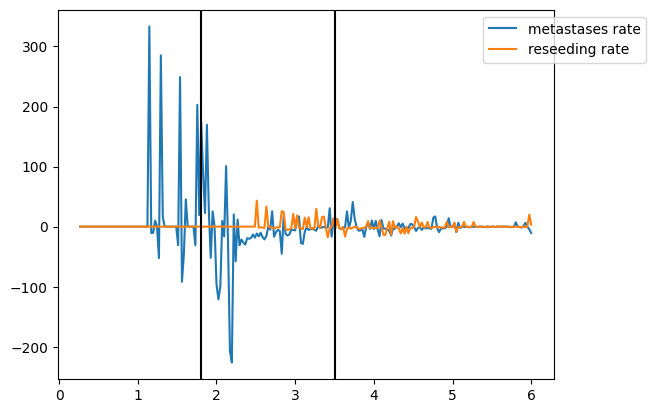

In [109]:
# xaxis_scaled = np.array(xaxis) * 6/xaxis[-1]
# p2n_intervals = (np.array(ydata['p2n_transition_norm'][1:]) - np.array(ydata['p2n_transition_norm'][:-1]))/(interval_step * scale)
# n2p_intervals = (np.array(ydata['n2p_transition_norm'][1:]) - np.array(ydata['n2p_transition_norm'][:-1]))/(interval_step * scale)

# plt.plot(xaxis_scaled[1:], p2n_intervals, label='metastases rate')
# plt.plot(xaxis_scaled[1:], n2p_intervals, label='reseeding rate')
# plt.axvline(1.8, color="black")
# plt.axvline(3.5, color="black")
# #plt.plot(xaxis_scaled, ydata['p2n_transition_norm'], label='# metastases events')
# # plt.plot(xaxis_scaled, ydata['n2p_transition_norm'], label='# reseeding events')
# # plt.plot(xaxis_scaled, ydata['n2n_transition_norm'], label='# metastasis to metastasis')
# plt.legend(bbox_to_anchor=(1.2, 1.00))

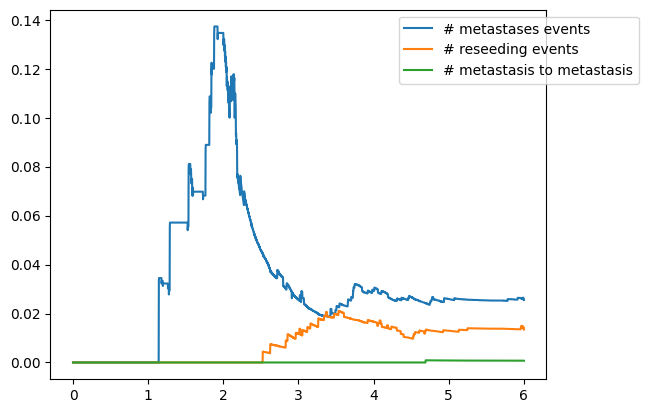

In [173]:
#plt.plot(xaxis, ydata['p2p_transition_norm'], label='primary to primary')
xaxis_scaled = np.array(xaxis) * 6/xaxis[-1]
plt.plot(xaxis_scaled, ydata['p2n_transition_norm'], label='# metastases events')
plt.plot(xaxis_scaled, ydata['n2p_transition_norm'], label='# reseeding events')
plt.plot(xaxis_scaled, ydata['n2n_transition_norm'], label='# metastasis to metastasis')
plt.legend(bbox_to_anchor=(1.2, 1.00))

In [40]:
ana_mapping = dict()
for i, name in enumerate(cell_site_info_1.unique()): 
    ana_mapping[i] = name

spatial_mapping = dict()
for i, name in enumerate(cell_site_info_2.unique()): 
    spatial_mapping[i] = name

In [69]:
cell_site_info_1.unique()

array(['3724_NT_T1', '3724_NT_S1', '3724_NT_L2', '3724_NT_L3',
       '3724_NT_L1'], dtype=object)

In [70]:
def setup_mapping(cell_to_annotations):
    mapping = dict()
    for i, name in enumerate(cell_to_annotations.unique()): 
        mapping[i] = name
    
    human_readable = {'3724_NT_L3': 'lung-metastasis-3',
                      '3724_NT_L2': 'lung-metastasis-2',
                      '3724_NT_L1': 'lung-metastasis-1',
                      '3724_NT_S1': 'soft-tissue-metastasis-1',
                      '3724_NT_T1': 'primary-tumor',
                     }
    
    for x in mapping:
        v = mapping[x]
        
        if v.startswith('T1'):
            loc = v.split('_')[1]
            s = f'primary-tumor-{loc}'
            human_readable[v] = s
        elif v.startswith('L'):
            loc = v.split('_')[1]
            s = f'lung-metastasis-2-{loc}'
            human_readable[v] = s
        elif v.startswith('S'):
            loc = v.split('_')[1]
            s = f'soft-tissue-2-{loc}'
            human_readable[v] = s
    return mapping, human_readable

In [44]:
def tree_to_newick_transitiontype(g, mapping, labeling, root=None):
    if root is None:
        roots = list(filter(lambda p: p[1] == 0, g.in_degree()))
        assert 1 == len(roots)
        root = roots[0][0]
    subgs = []
    for child in g[root]:
        weight = g[root][child]['weight']
        parent_label = human_readable[mapping[labeling[root]]]
        from_primary = True if parent_label.startswith('primary-tumor') else False        
        child_label = human_readable[mapping[labeling[child]]]
        to_primary = True if child_label.startswith('primary-tumor') else False
        
        if parent_label != child_label: 
            if from_primary:
                if to_primary:
                    transition_type = 'primary_to_primary'
                else:
                    transition_type = 'primary_to_nonprimary'
            else:
                if to_primary:
                    transition_type = 'nonprimary_to_primary'
                else:
                    transition_type = 'nonprimary_to_nonprimary'
                        
        if len(g[child]) > 0:
            if parent_label != child_label: 
                subgs.append(tree_to_newick_transitiontype(g, mapping, labeling, root=child) + f":{weight}[&type={transition_type}]")
            else:
                subgs.append(tree_to_newick_transitiontype(g, mapping, labeling, root=child) + f":{weight}") #[&type=non_transition]")
        else:
            subgs.append(child + f":{weight}")#[&type=leaf]")

    return "(" + ','.join(subgs) + ")" 

In [102]:
def tree_to_newick(g, human_readable, mapping, labeling, root=None):
    if root is None:
        roots = list(filter(lambda p: p[1] == 0, g.in_degree()))
        assert 1 == len(roots)
        root = roots[0][0]
    subgs = []
    parent_label = human_readable[mapping[labeling[root]]]
    for child in g[root]:
        child_label = human_readable[mapping[labeling[child]]]
        print(child_label)
        weight = g[root][child]['weight']
        if len(g[child]) > 0:
            subgs.append(tree_to_newick(g, human_readable, mapping, labeling, root=child)+ f"{child_label}:{weight}[&mig={child_label}]")
        else:
            subgs.append(child + f":{weight}[&mig={child_label}]")
    return "(" + ','.join(subgs) + ")" 


In [74]:
spa_optimal_labeling, spa_presence_labeling, spa_transitions, spa_sum_cost = count_transitions(problin_1461, cell_site_info_2, False)
ana_optimal_labeling, ana_presence_labeling, ana_transitions, ana_sum_cost = count_transitions(problin_1461, cell_site_info_1, False)
ana_mapping, ana_humanreadable = setup_mapping(cell_site_info_1)
spatial_mapping, spatial_humanreadable = setup_mapping(cell_site_info_2)


input tree has 2921 nodes and 1461 leaves
modified tree has 1461 leaves
input tree has 2921 nodes and 1461 leaves
modified tree has 1461 leaves


In [101]:
# def traverse_tree(g, root):
#     print(ana_humanreadable[ana_mapping[ana_optimal_labeling[root]]])
#     for child in g[root]:
#         traverse_tree(g, child)
# traverse_tree(problin_1461, 'root')

In [103]:
# anatomical location tree
ana_tree = tree_to_newick(problin_1461, ana_humanreadable, ana_mapping, ana_optimal_labeling, 'root')

with open("problin_1461.ana.nwk", "w+") as w:
    w.write(ana_tree + ';\n')
ana_tree

primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
lung-metastasis-3
primary-tumor
primary-tumor
lung-metastasis-1
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumor
primary-tumo

'((((L9.GAACATCTCTCTAGGA-1:1.4338149431260367[&mig=primary-tumor],(((L11.CGAGCACGTACCGAGA-1:0.5113228749087244[&mig=lung-metastasis-3],L8.CAAGAAAGTCGCGGTT-1:0.5113228749087244[&mig=primary-tumor])primary-tumor:0.005000661274110419[&mig=primary-tumor],L8.GTCAAGTGTTCCACAA-1:0.5163235361828349[&mig=primary-tumor])primary-tumor:0.0050035271521436[&mig=primary-tumor],L11.TAGTGGTTCATACGGT-1:0.5213270633349785[&mig=lung-metastasis-1])primary-tumor:0.912487875305582[&mig=primary-tumor])primary-tumor:0.3843457381117571[&mig=primary-tumor],L9.CTGCGGAGTAGGCTGA-1:1.818160681237794[&mig=primary-tumor])primary-tumor:0.46475513319561146[&mig=primary-tumor],L8.CGGAGCTTCGGAAATA-1:2.282915814433405[&mig=primary-tumor])primary-tumor:0.19311067051961742[&mig=primary-tumor],(((L8.TCGAGGCGTATAAACG-1:1.0860340747123287[&mig=primary-tumor],L8.GCTCCTAGTTCGTGAT-1:1.0860340747123287[&mig=primary-tumor])primary-tumor:0.5970955952415664[&mig=primary-tumor],L8.TCACGAATCCCATTAT-1:1.6831296699538951[&mig=primary-tumo

In [76]:
# transitiontype_tree = tree_to_newick_transitiontype(problin_1461, spatial_mapping, spa_optimal_labeling, 'root')


'((((L9.GAACATCTCTCTAGGA-1:1.4338149431260367,(((L11.CGAGCACGTACCGAGA-1:0.5113228749087244,L8.CAAGAAAGTCGCGGTT-1:0.5113228749087244)primary-tumor:0.005000661274110419,L8.GTCAAGTGTTCCACAA-1:0.5163235361828349)primary-tumor:0.0050035271521436,L11.TAGTGGTTCATACGGT-1:0.5213270633349785)primary-tumor:0.912487875305582)primary-tumor:0.3843457381117571,L9.CTGCGGAGTAGGCTGA-1:1.818160681237794)primary-tumor:0.46475513319561146,L8.CGGAGCTTCGGAAATA-1:2.282915814433405)primary-tumor:0.19311067051961742,(((L8.TCGAGGCGTATAAACG-1:1.0860340747123287,L8.GCTCCTAGTTCGTGAT-1:1.0860340747123287)primary-tumor:0.5970955952415664,L8.TCACGAATCCCATTAT-1:1.6831296699538951)primary-tumor:0.7878975489609431,((((((L9.GGGCACTAGTAACCCT-1:1.2476982448273093,L9.ACCTTTAGTCAAACTC-1:1.2476982448273093)primary-tumor:0.2855504152917709,L10.GTGCATAGTTATCCGA-1:1.5332486601190802)primary-tumor:0.47807429448957645,L8.CCGTACTCAGCTGCTG-1:2.011322954608657)primary-tumor:0.20151094888936197,(((L9.TTTATGCTCCAGTATG-1:1.82803097338713